In [21]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [22]:
# Load file 
xl = pd.ExcelFile('HighCr_input.xlsx')

# Load sheet as numpy array
HD = xl.parse('HessDeepAvg').as_matrix()
Gk = xl.parse('Gakkel').as_matrix()
SW = xl.parse('SWIR').as_matrix()
BW = xl.parse('BryndziaWood').as_matrix()
SW78 = xl.parse('SWIR_Plag').as_matrix()
Tonga = xl.parse('Tonga').as_matrix()

# Dictionary of values
D = {'Cr# (spl)':0,
     'Cr_std':1,
     'Mg# (spl)':2,
     'Mg_std':3,
     'Fe$^{3+}$/$\Sigma$Fe (spl)':4,
     'Fe3+/tFe_err':6,
     'wt% TiO$_2$ (spl)':7,
     'TiO2_std':8,
     'wt% NiO (spl)':9,
     'Fo# (olv)':10,
     '$X_{Fe}^{M1}*X_{Fe}^{M2}$ (opx)':11,
     'T (°C)':12,
     '$log(f_{O2})$, $\Delta$QFM':13,
     'plag':14,
     'ol/opx':15,
     'Al2O3':16,
     'fO2_err_pos':17,
     'fO2_err_neg':18,
     'T_std':19,
     'Ni_std':20,
     'Fo_prec':21,
     'XM1XM2_prec':22,
     'trace':23,
     'cpx_trace':24
    }

# Dictionary of error bar value
D_err = {'Cr# (spl)':[1,1],
        'Mg# (spl)':[3,3],
        'Fe$^{3+}$/$\Sigma$Fe (spl)':[6,6],
        'wt% TiO$_2$ (spl)':[8,8],
        '$log(f_{O2})$, $\Delta$QFM': [17,18],
        'T (°C)':[19,19],
        'wt% NiO (spl)':[20,20],
        'Fo# (olv)':[21,21],
        '$X_{Fe}^{M1}*X_{Fe}^{M2}$ (opx)':[22,22]}

Global = xl.parse('Global').as_matrix()
Cr_global = Global[:,0]
Yb_global = Global[:,1]
TiO2_global = Global[:,2]


In [31]:
# Trace element set-up

def trace_setup(sheet_name, data):
    cols = list(xl.parse(sheet_name).columns.values)

    cpx_tcol0 = cols.index('Li')
    cpx_tcol1 = cols.index('U')+1

    opx_tcol0 = cols.index('Li.1')
    opx_tcol1 = cols.index('U.1')+1

    trace_names = cols[cpx_tcol0:cpx_tcol1]

    cpx_trace_dicts = []
    for i in range(len(data)):
        trace_dict = {}
        for j, col in enumerate(trace_names):
            trace_dict[col] = data[i,cpx_tcol0 + j]
        trace_dict['Ti'] = trace_dict['TiO2%']*10000*47.867/79.866
        trace_dict['Gd'] = trace_dict['Gd(Dy)']
        cpx_trace_dicts.append(trace_dict)

    opx_trace_dicts = []
    for i in range(len(data)):
        trace_dict = {}
        for j, col in enumerate(trace_names):
            trace_dict[col] = data[i,opx_tcol0 + j]
        trace_dict['Ti'] = trace_dict['TiO2%']*10000*47.867/79.866 #ppm Ti from wt% TiO2
        trace_dict['Gd'] = trace_dict['Gd(Dy)']
        opx_trace_dicts.append(trace_dict)
    
    return cpx_trace_dicts, opx_trace_dicts
    

# Setting up normalizing values
Trace_info = xl.parse('Trace_info').as_matrix()
cols = list(xl.parse('Trace_info').columns.values)

cpx_tcol0 = cols.index('Li')
cpx_tcol1 = cols.index('U')+1

#opx_tcol0 = cols.index('Li.1')
#opx_tcol1 = cols.index('U.1')+1

trace_names = cols[cpx_tcol0:cpx_tcol1]

chon = {}
for j, col in enumerate(trace_names):
    chon[col] = Trace_info[0,j]
chon['Gd'] = chon['Gd(Dy)']
    
PUM = {}
for j, col in enumerate(trace_names):
    PUM[col] = Trace_info[1,j]
PUM['Ti'] = 1265 # ppm
PUM['Gd'] = PUM['Gd(Dy)']

cpx_trace_dicts, opx_trace_dicts = trace_setup('SWIR', SW)
cpx_trace_dicts_SWplag, opx_trace_dicts_SWplag = trace_setup('SWIR_Plag', SW78)

In [32]:
def fO2_plot(ax,x,y,locs,sz,fc,ec):
    
    if x in D_err: # If value has an x error bar:
        err_pos = D_err[x][0]
        err_neg = D_err[x][1]
        for i,loc in enumerate(locs): # For each location:
            ax.errorbar(loc[:,D[x]], loc[:,D[y]], xerr=[loc[:,err_neg], loc[:,err_pos]], linewidth=0, elinewidth=1, color='black',
                       zorder=0)
            
    if y in D_err: # If value has a y error bar:
        err_pos = D_err[y][0]
        err_neg = D_err[y][1]
        for i,loc in enumerate(locs): # For each location:
            ax.errorbar(loc[:,D[x]], loc[:,D[y]], yerr=[loc[:,err_neg], loc[:,err_pos]], linewidth=0, elinewidth=1, color='black',
                       zorder=0)
        
    for idx,loc in enumerate(locs):
        ax.scatter(loc[:,D[x]], loc[:,D[y]], 
                   marker=symbols[idx], s=sz[idx], c=fc[idx], edgecolors=ec[idx], cmap='bwr',label=labels[idx])

    #axes0.legend()#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    #ax.set_xlim([0,80])
    #axes0.set_ylim([0,0.30])
    ax.set_xlabel(x)
    ax.set_ylabel(y)
        

In [55]:
fig = plt.figure()
fig.set_size_inches(6, 9)

matplotlib.rc('font', size=9)

ax0 = fig.add_axes([0.05, 0.75, 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)
ax1 = fig.add_axes([0.55, 0.75, 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)
ax2 = fig.add_axes([0.05, 0.5, 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)
ax3 = fig.add_axes([0.55, 0.5, 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)
ax4 = fig.add_axes([0.05, 0.25, 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)
plt.gca().invert_xaxis()
ax5 = fig.add_axes([0.55, 0.25, 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)
ax6 = fig.add_axes([0.05, 0., 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)
plt.gca().invert_xaxis()
ax7 = fig.add_axes([0.55, 0.0, 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)

locations = [BW,SW,Gk,HD,SW78]
labels = ['Bryndzia and Wood', 'SWIR', 'Gakkel', 'Hess Deep', 'veined SWIR']
symbols = ['o','d','o','o','d']
sizes = [15,50,50,50,50]
facecolors = ['silver',SW[:,D['plag']],'lightgreen','yellow','darkred'] #SW[:,D['plag']]
edgecolors = ['silver','black','black','black', 'black']

fO2_plot(ax0,'Cr# (spl)','Fe$^{3+}$/$\Sigma$Fe (spl)',locations,sizes,facecolors,edgecolors)
fO2_plot(ax1,'Cr# (spl)','$log(f_{O2})$, $\Delta$QFM',locations,sizes,facecolors,edgecolors)
fO2_plot(ax2,'Cr# (spl)','wt% TiO$_2$ (spl)',locations,sizes,facecolors,edgecolors)
fO2_plot(ax3,'Cr# (spl)','T (°C)',locations,sizes,facecolors,edgecolors)
fO2_plot(ax4,'Mg# (spl)','Cr# (spl)',locations,sizes,facecolors,edgecolors)
fO2_plot(ax5,'Fo# (olv)','$X_{Fe}^{M1}*X_{Fe}^{M2}$ (opx)',locations,sizes,facecolors,edgecolors)
fO2_plot(ax6,'Fo# (olv)','Cr# (spl)',locations,sizes,facecolors,edgecolors)
fO2_plot(ax7,'Cr# (spl)','wt% NiO (spl)',locations,sizes,facecolors,edgecolors)

ax1.set_ylim([-5,3])
ax5.set_ylim([0.002,0.014])
ax2.legend(fontsize=8)

plt.savefig("hiCr_plots.eps", format="eps", bbox_inches="tight")
plt.savefig("hiCr_plots.pdf", format="pdf", bbox_inches="tight")
plt.savefig("hiCr_plots.png", format="png", bbox_inches="tight")
plt.show()


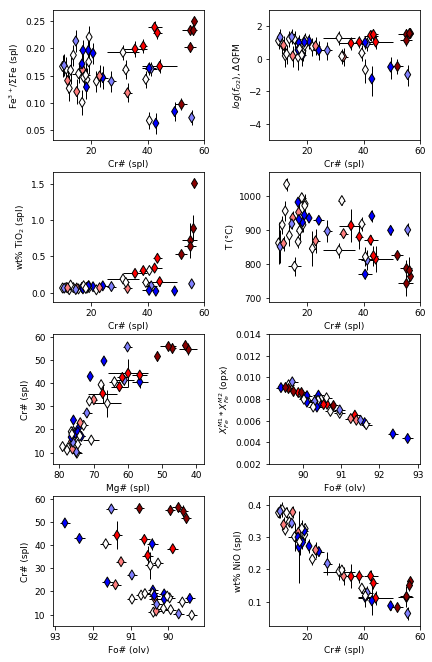

In [34]:
fig = plt.figure()
fig.set_size_inches(6, 9)

matplotlib.rc('font', size=9)

ax0 = fig.add_axes([0.05, 0.75, 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)
ax1 = fig.add_axes([0.55, 0.75, 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)
ax2 = fig.add_axes([0.05, 0.5, 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)
ax3 = fig.add_axes([0.55, 0.5, 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)
ax4 = fig.add_axes([0.05, 0.25, 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)
plt.gca().invert_xaxis()
ax5 = fig.add_axes([0.55, 0.25, 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)
ax6 = fig.add_axes([0.05, 0., 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)
plt.gca().invert_xaxis()
ax7 = fig.add_axes([0.55, 0.0, 0.35, 0.2]) # left, bottom, width, height (range 0 to 1)

symbols = ['d','d']
locations = [SW,SW78]
sizes = [50,50]
facecolors = [SW[:,D['plag']],'darkred'] 
edgecolors = ['black','black']

fO2_plot(ax0,'Cr# (spl)','Fe$^{3+}$/$\Sigma$Fe (spl)',locations,sizes,facecolors,edgecolors)
fO2_plot(ax1,'Cr# (spl)','$log(f_{O2})$, $\Delta$QFM',locations,sizes,facecolors,edgecolors)
fO2_plot(ax2,'Cr# (spl)','wt% TiO$_2$ (spl)',locations,sizes,facecolors,edgecolors)
fO2_plot(ax3,'Cr# (spl)','T (°C)',locations,sizes,facecolors,edgecolors)
fO2_plot(ax4,'Mg# (spl)','Cr# (spl)',locations,sizes,facecolors,edgecolors)
fO2_plot(ax5,'Fo# (olv)','$X_{Fe}^{M1}*X_{Fe}^{M2}$ (opx)',locations,sizes,facecolors,edgecolors)
fO2_plot(ax6,'Fo# (olv)','Cr# (spl)',locations,sizes,facecolors,edgecolors)
fO2_plot(ax7,'Cr# (spl)','wt% NiO (spl)',locations,sizes,facecolors,edgecolors)

ax1.set_ylim([-5,3])
ax5.set_ylim([0.002,0.014])

plt.savefig("hiCr_plots_plag.eps", format="eps", bbox_inches="tight")
plt.show()

In [35]:
fig = plt.figure()
fig.set_size_inches(8, 6)

axes0 = fig.add_axes([0.05, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

axes0.scatter(Cr_SW, Fe3_SW, s=80, c='silver', label='SWIR')
axes0.scatter(Cr_SW, Fe3_SW, s=80, c=SW[:,D['plag']], cmap='bwr',
              edgecolors='black', label='SWIR')
axes0.scatter(Cr_SW78, Fe3_SW78, s=80, c='darkred', edgecolors='black', label='SWIR Van78 Plag')

axes0.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

axes0.set_xlim([0,100])
axes0.set_ylim([0,0.30])
axes0.set_xlabel('spinel Cr#')
axes0.set_ylabel('Fe3+/tFe')

plt.savefig("Fe3_v_Cr_plag.eps", format="eps", bbox_inches="tight")
plt.show()

NameError: name 'Cr_SW' is not defined

In [36]:
fig = plt.figure()
fig.set_size_inches(4, 3)

axes0 = fig.add_axes([0.05, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

fO2_plot(axes0,'Cr#','log(fO2),dQFM',locations,sizes,facecolors,edgecolors)

axes0.set_ylim([-2,2])

plt.savefig("fO2_zoom.eps", format="eps", bbox_inches="tight")
plt.show()


KeyError: 'Cr#'

KeyError: 'Cr#'

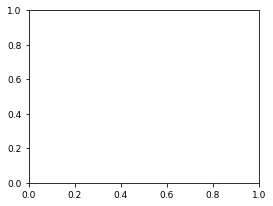

In [37]:
fig = plt.figure()
fig.set_size_inches(4, 3)

axes0 = fig.add_axes([0.05, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

fO2_plot(axes0,'Cr#','Al2O3',locations,sizes,facecolors,edgecolors)
#fO2_plot(axes0,'Al2O3','log(fO2),dQFM',locations,sizes,facecolors,edgecolors)

#axes0.set_ylim([-2,2])

plt.savefig("fO2_zoom.eps", format="eps", bbox_inches="tight")
plt.show()

## Trace Elements

In [38]:
print('--> Simple trace element plotters collapsed here')

def MgO_adjust(trace_dict, desired_MgO):
    
    adjusted_dict = {}
    
    for key in trace_dict:
        adjusted_dict[key] = trace_dict[key]*desired_MgO/trace_dict['MgO%']
        
    return adjusted_dict



def REE_plot(trace_dicts, group, colors, title):
    
    # Set up REE order and positions
    REEs = ['La','Ce','Pr','Nd','Sm','Eu','Gd(Dy)','Tb','Dy','Ho','Er','Tm','Yb']
    x_pos = [1,2,3,4,6,7,8,9,10,11,12,13,14] # Leaves a space for Pm
    
    # Set up figure
    fig = plt.figure()
    fig.set_size_inches(5, 4)
    
    ax = fig.add_axes([0.05, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
    
    # Perform calculations for each sample and plot
    for i, trace_dict in enumerate(trace_dicts):
        norm_chon = np.zeros(len(REEs))
        for j, el in enumerate(REEs):
            norm_chon[j] = trace_dict[el]/chon[el]
        color = colors[group[i]]
        ax.semilogy(x_pos, norm_chon, '-', c=color)
    
    ax.set_xlim([1,14])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(REEs)
    
    ax.set_ylim(10e-5,10e1)
    ax.set_ylabel('Conc/chon')
    
    ax.set_title(title)

    plt.show()
    
    return

def extended_REE_plot(trace_dicts, group, colors, title):
    
    # Set up REE order and positions
    REEs = ['Ba','Pb','Sr','Nb','Zr','Ti','Y','La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb']
    x_pos = [1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21] # Leaves a space for Pm
    
    # Set up figure
    fig = plt.figure()
    fig.set_size_inches(5, 4)
    
    ax = fig.add_axes([0.05, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
    
    # Perform calculations for each sample and plot
    for i, trace_dict in enumerate(trace_dicts):
        norm_PUM = np.zeros(len(REEs))
        for j, el in enumerate(REEs):
            norm_PUM[j] = trace_dict[el]/PUM[el]
        color = colors[group[i]]
        ax.semilogy(x_pos, norm_PUM, '-', c=color)
    
    ax.set_xlim([1,14])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(REEs)
    
    ax.set_ylim(10e-5,10e1)
    ax.set_ylabel('Conc/PUM')
    
    ax.set_title(title)

    plt.show()
    
    return

def trace_plot(trace_dicts, group, colors, title):
    # Plots trace elements, relative to PUM, in the order presented in Birner et al. (2017) which is based
    # on the order of Pearce and Parkinson (1992). Now with Tm included.
    
    # Set up trace element order and positions
    traces = ['Rb','Ba','Th','U','Ta','Nb','La','Ce','Pb','Pr','Sr',
              'Nd','Zr','Hf','Sm','Eu','Gd','Ti','Tb','Dy','Ho','Er','Tm','Yb']
    
    # Set up figure
    fig = plt.figure()
    fig.set_size_inches(5, 4)
    
    ax = fig.add_axes([0.05, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
    
    # Perform calculations for each sample and plot
    for i, trace_dict in enumerate(trace_dicts):
        norm_PUM = np.zeros(len(traces))
        for j, el in enumerate(traces):
            norm_PUM[j] = trace_dict[el]/PUM[el]
        color = colors[group[i]]
        ax.semilogy(range(len(traces)), norm_PUM, '-', c=color)
    
    ax.set_xlim([0,len(traces)])
    ax.set_xticks(range(len(traces)))
    ax.set_xticklabels(traces)
    
    ax.set_ylim(10e-5,10e1)
    ax.set_ylabel('Conc/PUM')
    
    ax.set_title(title)

    plt.show()
    
    return

def get_elem(trace_dicts, element):
    # Creates an array with the element of choice pulled out from each dictionary in
    # the list of dictionaries
    
    elem_array = np.zeros(len(trace_dicts))
    for i, trace_dict in enumerate(trace_dicts):
        elem_array[i] = trace_dict[element]
        
    return elem_array

--> Simple trace element plotters collapsed here


In [39]:
# Adjust SWIR peridotites to normalize to constant MgO values, because I don't have real values yet.
# Real data will go in here.

cpx_adjusted_dicts = []
for i, trace_dict in enumerate(cpx_trace_dicts):
    cpx_adjusted_dicts.append(MgO_adjust(trace_dict,18))
    
opx_adjusted_dicts = []
for i, trace_dict in enumerate(opx_trace_dicts):
    opx_adjusted_dicts.append(MgO_adjust(trace_dict,33))

In [40]:
### Pull out arrays of parameters of interest ###

# SWIR
Cr_num = SW[:,D['Cr# (spl)']]
TiO2 = SW[:,D['wt% TiO$_2$ (spl)']]
fO2 = SW[:,D['$log(f_{O2})$, $\Delta$QFM']]
plag_score = SW[:,D['plag']]
trace = SW[:,D['trace']]
La_N = get_elem(cpx_adjusted_dicts,'La')/chon['La']
Yb_N = get_elem(cpx_adjusted_dicts,'Yb')/chon['Yb']
Yb = get_elem(cpx_adjusted_dicts,'Yb')

# SWIR Van78 plag samples
Cr_num_SWplag = SW78[:,D['Cr# (spl)']]
TiO2_SWplag = SW78[:,D['wt% TiO$_2$ (spl)']]
fO2_SWplag = SW78[:,D['$log(f_{O2})$, $\Delta$QFM']]
plag_score_SWplag = SW78[:,D['plag']]
trace_SWplag = SW78[:,D['trace']]
La_N_SWplag = get_elem(cpx_trace_dicts_SWplag,'La')/chon['La']
Yb_N_SWplag = get_elem(cpx_trace_dicts_SWplag,'Yb')/chon['Yb']
Yb_SWplag = get_elem(cpx_trace_dicts_SWplag,'Yb')

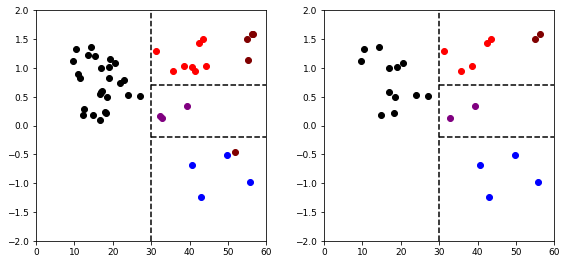

In [41]:
### Categorize SWIR peridotites ###
low_Cr = Cr_num<30
hi_Cr_hi_fO2 = (Cr_num>30) & (fO2>0.7)
hi_Cr_low_fO2 = (Cr_num>30) & (fO2<-0.2)
no_cat = (Cr_num>30) & (fO2>-0.2) & (fO2<0.7)  

### Plot categorizations ###

fig = plt.figure()
fig.set_size_inches(8, 4)
    
ax0 = fig.add_axes([0.05, 0.1, 0.4, 0.8]) # left, bottom, width, height (range 0 to 1)
ax1 = fig.add_axes([0.55, 0.1, 0.4, 0.8]) # left, bottom, width, height (range 0 to 1)

ax0.scatter(Cr_num[low_Cr], fO2[low_Cr], color='k')
ax0.scatter(Cr_num[hi_Cr_hi_fO2], fO2[hi_Cr_hi_fO2], color='r')
ax0.scatter(Cr_num[hi_Cr_low_fO2], fO2[hi_Cr_low_fO2], color='b')
ax0.scatter(Cr_num[no_cat], fO2[no_cat], color='purple')
ax0.scatter(Cr_num_SWplag, fO2_SWplag, color='maroon')

ax0.plot([30,60],[-0.2,-0.2], color='k', linestyle='--')
ax0.plot([30,60],[0.7,0.7], color='k', linestyle='--')
ax0.axvline(30, color='k', linestyle='--')

ax1.scatter(Cr_num[low_Cr & (trace==1)], fO2[low_Cr & (trace==1)], color='k')
ax1.scatter(Cr_num[hi_Cr_hi_fO2 & (trace==1)], fO2[hi_Cr_hi_fO2 & (trace==1)], color='r')
ax1.scatter(Cr_num[hi_Cr_low_fO2 & (trace==1)], fO2[hi_Cr_low_fO2 & (trace==1)], color='b')
ax1.scatter(Cr_num[no_cat & (trace==1)], fO2[no_cat & (trace==1)], color='purple')
ax1.scatter(Cr_num_SWplag[trace_SWplag==1], fO2_SWplag[trace_SWplag==1], color='maroon')

ax1.plot([30,60],[-0.2,-0.2], color='k', linestyle='--')
ax1.plot([30,60],[0.7,0.7], color='k', linestyle='--')
ax1.axvline(30, color='k', linestyle='--')

#ax.set_xscale('log')
#ax.set_yscale('log')

ax0.set_xlim([0,60])
ax0.set_ylim([-2,2])

ax1.set_xlim([0,60])
ax1.set_ylim([-2,2])

plt.show()

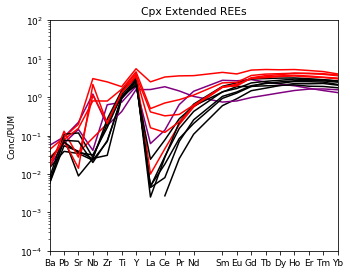

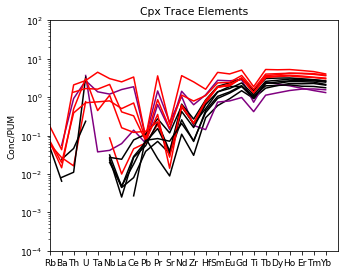

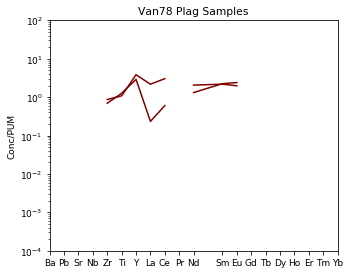

In [42]:
category = [] 
for i in range(len(SW)):
    if low_Cr[i] == True:
        category.append(0)
    elif hi_Cr_hi_fO2[i] == True:
        category.append(1)
    elif hi_Cr_low_fO2[i] == True:
        category.append(2)
    else:
        category.append(3)

cat_names = ['Low Cr#','High Cr#, high fO2', 'High Cr#, low fO2', 'Uncategorized']

REE_plot(cpx_adjusted_dicts, category, {0:'k',1:'r',2:'b',3:'purple'}, 'Cpx REEs')
extended_REE_plot(cpx_adjusted_dicts, category, {0:'k',1:'r',2:'b',3:'purple'}, 'Cpx Extended REEs')
trace_plot(cpx_adjusted_dicts, category, {0:'k',1:'r',2:'b',3:'purple'}, 'Cpx Trace Elements')

extended_REE_plot(cpx_trace_dicts_SWplag, np.zeros(len(cpx_trace_dicts_SWplag)), {0:'maroon'}, 'Van78 Plag Samples')

In [43]:
fig = plt.figure()
fig.set_size_inches(4, 3)
    
ax0 = fig.add_axes([0.05, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

ax0.scatter(Cr_global, Yb_global, s=10, color='silver')

ax0.scatter(Cr_num[low_Cr], Yb[low_Cr], color='k')
ax0.scatter(Cr_num[hi_Cr_hi_fO2], Yb[hi_Cr_hi_fO2], color='r')
ax0.scatter(Cr_num[hi_Cr_low_fO2], Yb[hi_Cr_low_fO2], color='b')
ax0.scatter(Cr_num[no_cat], Yb[no_cat], color='purple')
ax0.scatter(Cr_num_SWplag, Yb_SWplag, color='maroon')

ax0.set_xlim([0,60])
ax0.set_ylim([10e-2,2.5*10e-1])
ax0.set_yscale('log')
ax0.set_xlabel('Cr# in Spinel')
ax0.set_ylabel('Yb (ppm) in Cpx')

plt.show()

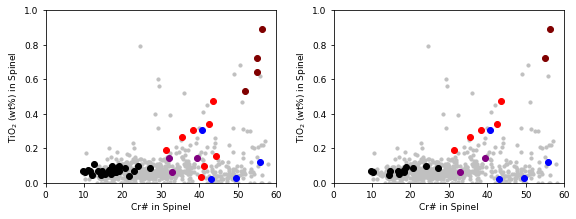

In [44]:
fig = plt.figure()
fig.set_size_inches(8, 3)
    
ax0 = fig.add_axes([0.05, 0.1, 0.4, 0.8]) # left, bottom, width, height (range 0 to 1)
ax1 = fig.add_axes([0.55, 0.1, 0.4, 0.8]) # left, bottom, width, height (range 0 to 1)

ax0.scatter(Cr_global, TiO2_global, s=10, color='silver')

ax0.scatter(Cr_num[low_Cr], TiO2[low_Cr], color='k')
ax0.scatter(Cr_num[hi_Cr_hi_fO2], TiO2[hi_Cr_hi_fO2], color='r')
ax0.scatter(Cr_num[hi_Cr_low_fO2], TiO2[hi_Cr_low_fO2], color='b')
ax0.scatter(Cr_num[no_cat], TiO2[no_cat], color='purple')
ax0.scatter(Cr_num_SWplag, TiO2_SWplag, color='maroon')

ax1.scatter(Cr_global, TiO2_global, s=10, color='silver')

ax1.scatter(Cr_num[low_Cr & (trace==1)], TiO2[low_Cr & (trace==1)], color='k')
ax1.scatter(Cr_num[hi_Cr_hi_fO2 & (trace==1)], TiO2[hi_Cr_hi_fO2 & (trace==1)], color='r')
ax1.scatter(Cr_num[hi_Cr_low_fO2 & (trace==1)], TiO2[hi_Cr_low_fO2 & (trace==1)], color='b')
ax1.scatter(Cr_num[no_cat & (trace==1)], TiO2[no_cat & (trace==1)], color='purple')
ax1.scatter(Cr_num_SWplag[trace_SWplag==1], TiO2_SWplag[trace_SWplag==1], color='maroon')

ax0.set_xlim([0,60])
ax0.set_ylim([0,1])
ax0.set_xlabel('Cr# in Spinel')
ax0.set_ylabel('TiO$_2$ (wt%) in Spinel')

ax1.set_xlim([0,60])
ax1.set_ylim([0,1])
ax1.set_xlabel('Cr# in Spinel')
ax1.set_ylabel('TiO$_2$ (wt%) in Spinel')

plt.show()

In [45]:
plag

NameError: name 'plag' is not defined

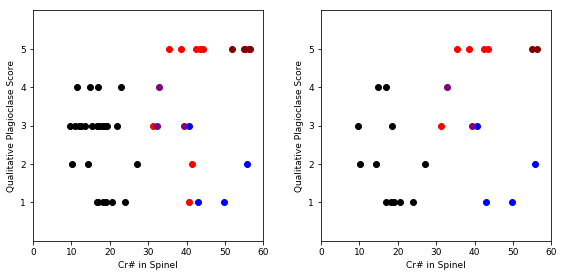

In [46]:
fig = plt.figure()
fig.set_size_inches(8, 4)
    
ax0 = fig.add_axes([0.05, 0.1, 0.4, 0.8]) # left, bottom, width, height (range 0 to 1)
ax1 = fig.add_axes([0.55, 0.1, 0.4, 0.8]) # left, bottom, width, height (range 0 to 1)

ax0.scatter(Cr_num[low_Cr], plag_score[low_Cr], color='k')
ax0.scatter(Cr_num[hi_Cr_hi_fO2], plag_score[hi_Cr_hi_fO2], color='r')
ax0.scatter(Cr_num[hi_Cr_low_fO2], plag_score[hi_Cr_low_fO2], color='b')
ax0.scatter(Cr_num[no_cat], plag_score[no_cat], color='purple')
ax0.scatter(Cr_num_SWplag, plag_score_SWplag, color='maroon')

ax1.scatter(Cr_num[low_Cr & (trace==1)], plag_score[low_Cr & (trace==1)], color='k')
ax1.scatter(Cr_num[hi_Cr_hi_fO2 & (trace==1)], plag_score[hi_Cr_hi_fO2 & (trace==1)], color='r')
ax1.scatter(Cr_num[hi_Cr_low_fO2 & (trace==1)], plag_score[hi_Cr_low_fO2 & (trace==1)], color='b')
ax1.scatter(Cr_num[no_cat & (trace==1)], plag_score[no_cat & (trace==1)], color='purple')
ax1.scatter(Cr_num_SWplag[trace_SWplag==1], plag_score_SWplag[trace_SWplag==1], color='maroon')

ax0.set_xlim([0, 60])
ax0.set_ylim([0,6])
ax0.set_yticks([1,2,3,4,5])
ax0.set_xlabel('Cr# in Spinel')
ax0.set_ylabel('Qualitative Plagioclase Score')
ax1.set_xlim([0, 60])
ax1.set_ylim([0,6])
ax1.set_yticks([1,2,3,4,5])
ax1.set_xlabel('Cr# in Spinel')
ax1.set_ylabel('Qualitative Plagioclase Score')

plt.show()

## Trace Element Modeling

In [47]:
def fractional_melting(plotting=True):
    
    init_modes = {
        'olv': 0.57, 
        'opx': 0.28, 
        'cpx': 0.13, 
        'spl': 0.02, 
        'plg': 0} # Workman and Hart, 2005. Are these modes volume modes, e.g., like point counting?
    rxn_modes = { 
        'olv': -0.34, 
        'opx': 0.56, 
        'cpx': 0.72, 
        'spl': 0.04, 
        'plg': 0} # Wasylenki et al. 2003, DMM1 at 1.0 GPa. Note that these are WEIGHT fractions, not mole fractions
                    # or volume fractions?
    DMM = {     
        'Ba': 0.563,
        'Pb': 0.018,
        'Sr': 7.664,
        'Nb': 0.1485,
        'Zr': 5.082,
        'Ti': 716.3,
        'Y' : 3.328,
        'La': 0.192,
        'Ce': 0.550,
        'Pr': 0.107,
        'Nd': 0.581,
        'Sm': 0.239,
        'Eu': 0.096,
        'Gd': 0.358,
        'Tb': 0.070,
        'Dy': 0.505,
        'Ho': 0.115,
        'Er': 0.348,
        'Yb': 0.365} # Workman and Hart, 2005
    
    # Partition coefficients

    # ol, opx from JMW's Liang REE text file
    # cpx updated to be Sun and Liang 2012
    # sp from Kelemen 2003
    # plag from Aigner-Torres et al., 2007
    
    D = {
        'Ba' : {'olv':1e-9,      'opx':0.00001, 'cpx':0.00068, 'spl':0,      'plg':0.247},
        'Pb' : {'olv':0.00001,   'opx':0.003,   'cpx':0.072,   'spl':0,      'plg':1.592},
        'Sr' : {'olv':0.00001,   'opx':0.003,   'cpx':0.1283,  'spl':0,      'plg':1.629},
        'Nb' : {'olv':0.001,     'opx':0.0029,  'cpx':0.0077,  'spl':0.01,   'plg':0.097},
        'Zr' : {'olv':0.004,     'opx':0.04,    'cpx':0.1234,  'spl':0.07,   'plg':0.001},
        'Ti' : {'olv':0.015,     'opx':0.15,    'cpx':0.4,     'spl':0.15,   'plg':0.038},
        'Y'  : {'olv':0.023,     'opx':0.1,     'cpx':0.467,   'spl':0.0045, 'plg':0.008},
        'La' : {'olv':0.0000023, 'opx':0.00074, 'cpx':0.0550,  'spl':0.0006, 'plg':0.077},
        'Ce' : {'olv':0.0000073, 'opx':0.0016,  'cpx':0.0876,  'spl':0.0006, 'plg':0.054},
        'Pr' : {'olv':0.000021,  'opx':0.0032,  'cpx':0.1318,  'spl':0.0006, 'plg':0.042},
        'Nd' : {'olv':0.000058,  'opx':0.0060,  'cpx':0.1878,  'spl':0.0006, 'plg':0.054},
        'Sm' : {'olv':0.00029,   'opx':0.0158,  'cpx':0.3083,  'spl':0.001,  'plg':0.081},
        'Eu' : {'olv':0.00055,   'opx':0.0227,  'cpx':0.3638,  'spl':0.001,  'plg':0.109},
        'Gd' : {'olv':0.0010,    'opx':0.0315,  'cpx':0.4169,  'spl':0.0006, 'plg':0.042},
        'Tb' : {'olv':0.0017,    'opx':0.0422,  'cpx':0.4645,  'spl':0.0006, 'plg':0.028},
        'Dy' : {'olv':0.0029,    'opx':0.0549,  'cpx':0.5034,  'spl':0.002,  'plg':0.049},
        'Ho' : {'olv':0.0045,    'opx':0.0680,  'cpx':0.5294,  'spl':0.0023, 'plg':0.052},
        'Er' : {'olv':0.0066,    'opx':0.0808,  'cpx':0.5437,  'spl':0.003,  'plg':0.057},
        #'Tm':{'plg':0.061},
        'Yb' : {'olv':0.0121,    'opx':0.1036,  'cpx':0.5453,  'spl':0.005,  'plg':0.025}
    }
    
    weighted_liq_D = {REE: sum(rxn_modes[mineral]*D[REE][mineral] for mineral in D[REE]) for REE in D}
    D_bulk_DMM = {REE: sum(init_modes[mineral]*D[REE][mineral] for mineral in D[REE]) for REE in D}
    cpx_DMM = {REE: DMM[REE]*D[REE]['cpx'] / D_bulk_DMM[REE] for REE in D}
    
    cpx_out = init_modes['cpx']/rxn_modes['cpx']
    degrees_of_melting = np.arange(0,cpx_out,0.001)
    
    melt_residues = {}
    for F in degrees_of_melting:
        modes = {mineral: (init_modes[mineral] - F*rxn_modes[mineral]) / sum({mineral: init_modes[mineral] - F*rxn_modes[mineral]
                for mineral in init_modes}.values()) for mineral in init_modes}
        #print(modes)
        D_bulk = {REE: sum({modes[mineral]*D[REE][mineral] for mineral in D[REE]})
                 for REE in D}
        X_bulk = {REE: DMM[REE] / (1-F) * (1 - F*weighted_liq_D[REE]/D_bulk_DMM[REE])**(1/weighted_liq_D[REE])
                 for REE in DMM}
        #print(X_bulk)
        #print(D_bulk)
        X_cpx = {REE: X_bulk[REE]*D[REE]['cpx'] / D_bulk[REE]
                for REE in DMM}
        X_cpx_norm = {REE: X_cpx[REE]/PUM[REE]
                for REE in DMM}
        
        percent_melt = 100*F
        F_str = "%.1f" % percent_melt + "%"
        
        melt_residues[F_str] = {}
        melt_residues[F_str]['modes'] = modes
        melt_residues[F_str]['D_bulk'] = D_bulk
        melt_residues[F_str]['X_bulk'] = X_bulk
        melt_residues[F_str]['X_cpx'] = X_cpx
        melt_residues[F_str]['X_cpx_norm'] = X_cpx_norm
        
    REEs = ['Ba','Pb','Sr','Nb','Zr','Ti','Y','La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Yb']
    x_pos = [1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,21] # Leaves a space for Pm and Tm
    
    F00 = np.zeros(len(REEs))
    F05 = np.zeros(len(REEs))
    F10 = np.zeros(len(REEs))
    F15 = np.zeros(len(REEs))
    for idx,REE in enumerate(REEs):
        #print(melt_residues['0.0%'])
        #print(melt_residues['0.0%']['X_cpx_norm'])
        #print(melt_residues['0.0%']['X_cpx_norm'][REE])
        F00[idx] = melt_residues['0.0%']['X_cpx_norm'][REE]
        F05[idx] = melt_residues['5.0%']['X_cpx_norm'][REE]
        F10[idx] = melt_residues['10.0%']['X_cpx_norm'][REE]
        F15[idx] = melt_residues['15.0%']['X_cpx_norm'][REE]
        
    if plotting==True:
        fig = plt.figure()
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

        ax.plot(x_pos, F00, 'k')
        ax.plot(x_pos, F05,'k')
        ax.plot(x_pos, F10, 'k')
        ax.plot(x_pos, F15,'k')

        ax.set_yscale('log')   
        ax.set_ylim([10e-6, 10e1])
        ax.set_xlim([min(x_pos), max(x_pos)])
        ax.set_xticks(x_pos)
        ax.set_xticklabels(REEs, fontsize=10)
        ax.set_ylabel('Conc/PUM')

        plt.show()
    
    return melt_residues
        
    

def melt_model(cpx_trace_dicts, melt_to_add, xtal_modes, normalization=chon, method='standard', 
                subsolidus_reaction=False, ss_rxn_amt=[1,0,1], group_color='k', plot_title='', output=True, model_plot='individual',
                  speed='fast'):
    # Finds the best fit by varying the parameters of (1) degree of fractional melting and (2) degree of melt addition
        
    # Need to add Tm back in
    
    # Set up REE order and positions
    if method == 'custom1': # model the REEs only, but show the extended pattern to see what you're getting wrong
        modeled_elements = ['La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Yb']
        plotted_elements = ['Ba','Sr','Zr','Ti','Y','La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Yb']
        x_pos = [1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,19] # Leaves a space for Pm and Tm
    elif method == 'custom2': # extended suite minus Pb and Nb, which never behave
        modeled_elements = ['Ba','Sr','Zr','Ti','Y','La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Yb']
        plotted_elements = ['Ba','Sr','Zr','Ti','Y','La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Yb']
        x_pos = [1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,19] # Leaves a space for Pm and Tm
    elif method == 'extended':
        modeled_elements = ['Ba','Pb','Sr','Nb','Zr','Ti','Y','La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Yb']
        plotted_elements = ['Ba','Pb','Sr','Nb','Zr','Ti','Y','La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Yb']
        x_pos = [1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,21] # Leaves a space for Pm and Tm
    elif method == 'standard':
        modeled_elements = ['La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Yb']
        plotted_elements = ['La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Yb']
        x_pos = [1,2,3,4,6,7,8,9,10,11,12,14] # Leaves a space for Pm and Tm
        
    # Partition coefficients

    # ol, opx from JMW's Liang REE text file
    # cpx updated to be Sun and Liang 2012
    # sp from Kelemen 2003
    # plag from Aigner-Torres et al., 2007
    
    D = {
        'Ba' : {'olv':1e-9,      'opx':0.00001, 'cpx':0.00068, 'spl':0,      'plg':0.247},
        'Pb' : {'olv':0.00001,   'opx':0.003,   'cpx':0.072,   'spl':0,      'plg':1.592},
        'Sr' : {'olv':0.00001,   'opx':0.003,   'cpx':0.1283,  'spl':0,      'plg':1.629},
        'Nb' : {'olv':0.001,     'opx':0.0029,  'cpx':0.0077,  'spl':0.01,   'plg':0.097},
        'Zr' : {'olv':0.004,     'opx':0.04,    'cpx':0.1234,  'spl':0.07,   'plg':0.001},
        'Ti' : {'olv':0.015,     'opx':0.15,    'cpx':0.4,     'spl':0.15,   'plg':0.038},
        'Y'  : {'olv':0.023,     'opx':0.1,     'cpx':0.467,   'spl':0.0045, 'plg':0.008},
        'La' : {'olv':0.0000023, 'opx':0.00074, 'cpx':0.0550,  'spl':0.0006, 'plg':0.077},
        'Ce' : {'olv':0.0000073, 'opx':0.0016,  'cpx':0.0876,  'spl':0.0006, 'plg':0.054},
        'Pr' : {'olv':0.000021,  'opx':0.0032,  'cpx':0.1318,  'spl':0.0006, 'plg':0.042},
        'Nd' : {'olv':0.000058,  'opx':0.0060,  'cpx':0.1878,  'spl':0.0006, 'plg':0.054},
        'Sm' : {'olv':0.00029,   'opx':0.0158,  'cpx':0.3083,  'spl':0.001,  'plg':0.081},
        'Eu' : {'olv':0.00055,   'opx':0.0227,  'cpx':0.3638,  'spl':0.001,  'plg':0.109},
        'Gd' : {'olv':0.0010,    'opx':0.0315,  'cpx':0.4169,  'spl':0.0006, 'plg':0.042},
        'Tb' : {'olv':0.0017,    'opx':0.0422,  'cpx':0.4645,  'spl':0.0006, 'plg':0.028},
        'Dy' : {'olv':0.0029,    'opx':0.0549,  'cpx':0.5034,  'spl':0.002,  'plg':0.049},
        'Ho' : {'olv':0.0045,    'opx':0.0680,  'cpx':0.5294,  'spl':0.0023, 'plg':0.052},
        'Er' : {'olv':0.0066,    'opx':0.0808,  'cpx':0.5437,  'spl':0.003,  'plg':0.057},
        #'Tm':{'plg':0.061},
        'Yb' : {'olv':0.0121,     'opx':0.1036,  'cpx':0.5453,  'spl':0.005,  'plg':0.025}
    }
    
    # Melt-added fractions of interest
    melt_F1 = np.arange(0,0.0001,0.00001) # 0% to 0.0001%; 10 steps
    melt_F2 = np.arange(0.0001,0.001,0.0001) # 0.0001% to 0.001%; 10 steps
    melt_F3 = np.arange(0.001,0.01,0.001) # 0.001% to 0.01%; 10 steps
    if speed == 'fast':
        melt_F4 = np.arange(0.01,0.1,0.01) # 0.01% to 0.1%; 10 steps
        melt_F5 = np.arange(0.1,1,0.1) # 0.1% to 1%; 10 steps
        melt_F6 = np.arange(1,10,1) # 1% to 10%; 10 steps
    else:
        melt_F4 = np.arange(0.01,0.1,0.001) # 0.01% to 0.1%; 100 steps
        melt_F5 = np.arange(0.1,1,0.01) # 0.1% to 1%; 100 steps
        melt_F6 = np.arange(1,10,0.1) # 1% to 10%; 100 steps   
    melt_F7 = np.arange(10,100,10) # 10% to 100%; 10 steps
    melt_F = np.concatenate((melt_F1,melt_F2,melt_F3,melt_F4,melt_F5,melt_F6,melt_F7),axis=0)
    
    # Get fractional melting outputs from 0 to 18% fractional melting, in 0.1% steps
    fractional_output = fractional_melting(plotting=False)
    
    # Normalize xtal modes
    xtal_modes_norm = {element: 
                            xtal_modes[element]/sum(xtal_modes.values())
                            for element in xtal_modes}
    
    # Set up plots
    
    fig = plt.figure()
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
    
    ### Find optimized parameters ###
    
    # Initialize variables for all samples
    F_bf_all = np.zeros(len(cpx_trace_dicts))
    Fm_bf_all = np.zeros(len(cpx_trace_dicts))
    Cr_num_res_all = np.zeros(len(cpx_trace_dicts))
    Cr_num_new_all = np.zeros(len(cpx_trace_dicts))
    
    # Initialize variables for each sample
    F_min = np.inf # initialize looking for lowest degree of melting
    F_max = 0 # initialize looking for highest degree of melting
    Fm_min = np.inf # initialize looking for lowest degree of melt addition
    Fm_max = 0 # initialize looking for highest degree of melt addition
    pattern_min = np.full((1, len(plotted_elements)), np.inf) # initialize looking for the lower bound of model
    pattern_max = np.zeros((1, len(plotted_elements))) # initialize looking for the upper bound of model
    
    for i, cpx_trace_dict in enumerate(cpx_trace_dicts): 
        chi_min = False
        for F in fractional_output:
            for m100 in melt_F:
                
                m = m100/100
                # Bulk, unnormalized REEs for residual solid
                X_bulk_residue = fractional_output[F]['X_bulk']
                # Modes within residual peridotite
                modes_residue = fractional_output[F]['modes']

                # Bulk, unnormalized REEs for residual solid+melt
                X_bulk_residue_plus_melt = {element: 
                                            (1-m)*X_bulk_residue[element] + m*melt_to_add[element] 
                                            for element in X_bulk_residue}

                # calculate new modes for solid+melt
                solid_melt_modes = {mineral: 
                             (1-m)*modes_residue[mineral] + m*xtal_modes_norm[mineral] 
                             for mineral in modes_residue}

                if subsolidus_reaction == 'spinel-to-plag':
                    # reaction modes are WEIGHT modes for reaction CaAl2Si2O8 + 2*Mg2SiO4 = Mg2Si2O6 + MgCaSi2O6 + MgAl2O4
                    #degree_of_rxn = ss_rxn_amt[0]*m100 + ss_rxn_amt[1]
                    degree_of_rxn = ss_rxn_amt[0]*np.log(m100*ss_rxn_amt[2] + 1) + ss_rxn_amt[1] # amount for reaction to occur
                    rxn_modes = {'olv':1.98, 'opx':-1.41, 'cpx':-1.52, 'spl':-1, 'plg':1.96} # From Borghini 2010
                    new_modes = {mineral: 
                             solid_melt_modes[mineral] + degree_of_rxn*rxn_modes[mineral]
                             for mineral in solid_melt_modes}
                else:
                    new_modes = solid_melt_modes

                #########
                # Cr# calculations

                # calculate Cr# for new solid+melt peridotite
                Cr_res = np.exp((float(F[0:-1])-23)/9) # Cr# of residual peridotite, calculated using formula in Warren 2016
                Mg_res = -0.003489*Cr_res + 0.81211 # Mg# of residual peridotite, calculated using global correlation between
                                                        # Cr# and Mg# for ridge peridotites (AllGlobal... Sheet3)
                X_Cr = Cr_res
                X_Al = 1-Cr_res
                X_Mg = Mg_res
                X_Fe = 1-Mg_res
                # Total spinel formula is: (Mg,Fe)(Cr,Al)2O4

                # Calculate g of each endmember for 1 mol spinel
                g_MgFeCr2O4 = X_Cr*(X_Mg*24.305 + X_Fe*71.844 + 2*51.9961 + 4*15.999)
                g_MgFeAl2O4 = X_Al*(X_Mg*24.305 + X_Fe*71.844 + 2*26.9815 + 4*15.999)
                total = g_MgFeCr2O4 + g_MgFeAl2O4

                # g of spinel in residual peridotite, prior to melt addition or subsolidus changes
                g_sp = modes_residue['spl']

                # calculate g of Al and Cr endmembers within 1 g of modeled residual peridotite
                g_MgFeCr2O4_abs = g_sp*g_MgFeCr2O4/total
                g_MgFeAl2O4_abs = g_sp*g_MgFeAl2O4/total

                # calculate g of spinel lost after melt addition and subsolidus changes (delta_spinel should be negative
                        # if spinel is going into plagioclase)
                delta_spinel = new_modes['spl'] - modes_residue['spl']

                # assume all lost spinel is (MgFe)Al2O4, with Mg/Fe ratio as calculated above
                # calculate g of MgFeAl2O4 lost
                g_MgFeCr2O4_abs_new = g_MgFeCr2O4_abs + 0
                g_MgFeAl2O4_abs_new = g_MgFeAl2O4_abs + delta_spinel

                # calculate mol of updated spinel endmembers
                X_MgFeCr2O4_abs_new = g_MgFeCr2O4_abs_new/(X_Mg*24.305 + X_Fe*71.844 + 2*51.9961 + 4*15.999)
                X_MgFeAl2O4_abs_new = g_MgFeAl2O4_abs_new/(X_Mg*24.305 + X_Fe*71.844 + 2*26.9815 + 4*15.999)

                Cr_num_new = X_MgFeCr2O4_abs_new/(X_MgFeCr2O4_abs_new + X_MgFeAl2O4_abs_new)


                ##########
                # calculate new bulk partition coefficient
                D_bulk = {element: 
                          sum({new_modes[mineral]*D[element][mineral] for mineral in D[element]})
                          for element in D}

                # calculate cpx for solid-melt hybrid from bulk         
                X_cpx = {element: 
                         X_bulk_residue_plus_melt[element]*D[element]['cpx'] / D_bulk[element] 
                         for element in X_bulk_residue_plus_melt}

                # calculate plagioclase for solid-melt hybrid from bulk
                X_plg = {element: 
                         X_bulk_residue_plus_melt[element]*D[element]['plg'] / D_bulk[element] 
                         for element in X_bulk_residue_plus_melt}

                # calculate misfit between data and model
                model = X_cpx
                data = cpx_trace_dict

                misfit = {element: 
                          abs(model[element]-data[element])/data[element] 
                          for element in modeled_elements}
                vals = np.fromiter(misfit.values(), dtype=float)
                chi_squared = np.nansum(vals) 

                if chi_min == False or chi_squared < chi_min:
                    chi_min = chi_squared
                    #chi_v = chi_squared_v
                    best_fit = model
                    plag_bf = X_plg
                    F_bf = float(F[0:-1])
                    Fm_bf = m100
                    orig_modes = modes_residue
                    modes_bf = new_modes
                    residue_cpx_bf  = {element: 
                         X_bulk_residue[element]*D[element]['cpx'] / fractional_output[F]['D_bulk'][element] 
                         for element in X_bulk_residue}
                    Cr_res_bf = 100*Cr_res
                    Cr_new_bf = 100*Cr_num_new
        
        if output == True:
            print('Melting: %.1f%%' % F_bf)
            print('Melt Addition: %.3f%%' % Fm_bf)
            print('Chi Squared: %.5f' % chi_min)
            print('Original Modes: ', orig_modes)
            print('New Modes: ', modes_bf)
            print('Original Cr#: %.1f' % Cr_res_bf)
            print('New Cr#: %.1f' % Cr_new_bf)
        
        # check whether the best fit is a new min or max in terms of degree of melting or melt addition
        if F_bf < F_min:
            F_min = F_bf
        if F_bf > F_max:
            F_max = F_bf
        if Fm_bf < Fm_min:
            Fm_min = Fm_bf
        if Fm_bf > Fm_max:
            Fm_max = Fm_bf
            
        # calculate the concentration of trace elements in DMM
        X_cpx_DMM = {element: 
                     fractional_output['0.0%']['X_bulk'][element]*D[element]['cpx'] / fractional_output['0.0%']['D_bulk'][element] 
                for element in X_bulk_residue}
        
        # turn dictionaries into ordered lists for plotting
        data_ordered_normalized = []
        model_ordered_normalized = []
        DMM_ordered_normalized = []
        melt_ordered_normalized = []
        residue_ordered_normalized = []
        plot_modeled_normalized = [] # Only the data elements that were modeled (i.e., data that the model is trying to fit)
        plag_ordered_normalized = []
        for element in plotted_elements:
            data_ordered_normalized.append(data[element]/normalization[element])
            model_ordered_normalized.append(best_fit[element]/normalization[element])
            DMM_ordered_normalized.append(X_cpx_DMM[element]/normalization[element])
            melt_ordered_normalized.append(melt_to_add[element]/normalization[element])
            residue_ordered_normalized.append(residue_cpx_bf[element]/normalization[element])
            if element in modeled_elements:
                plot_modeled_normalized.append(best_fit[element]/normalization[element])
            else:
                plot_modeled_normalized.append(np.nan)
            plag_ordered_normalized.append(plag_bf[element]/normalization[element])
            
        # determine whether any elements are the lowest or highest
        
        for idx, X_element in enumerate(model_ordered_normalized):
            if X_element < pattern_min[0,idx]:
                pattern_min[0,idx] = X_element
            if X_element > pattern_max[0,idx]:
                pattern_max[0,idx] = X_element

        # plot output
        axes.plot(x_pos, data_ordered_normalized, group_color, linewidth=2, zorder=100)
        #axes.scatter(x_pos, plot_modeled_normalized, color='k')
        if model_plot=='individual':
            axes.plot(x_pos, model_ordered_normalized, color='silver', linewidth=8, zorder=0)
            axes.plot(x_pos, model_ordered_normalized, color='dimgray', linewidth=2, zorder=1)
        #axes.plot(x_pos, residue_ordered_normalized,'r--')
        #axes.plot(x_pos, plag_ordered_normalized,'orange')
        
        # add parameters to output variables
        F_bf_all[i] = F_bf
        Fm_bf_all[i] = Fm_bf
        Cr_num_res_all[i] = Cr_res_bf
        Cr_num_new_all[i] = Cr_new_bf

    
    ### Back to highest level of function, after all samples have been processed ###
    
    axes.plot(x_pos, DMM_ordered_normalized, 'k--')
    axes.plot(x_pos, melt_ordered_normalized,'b-')
    
    if model_plot=='group':
        axes.fill_between(x_pos, pattern_min[0,:], pattern_max[0,:], color='silver', zorder=0)
    
    axes.text(0.99, 0.1, 'Fractional Melting: %.1f%% - %.1f%%' % (F_min, F_max), horizontalalignment='right',
        verticalalignment='bottom', transform=axes.transAxes)
    axes.text(0.99, 0.05, 'Melt Addition: %.3f%% - %.3f%%' % (Fm_min, Fm_max), horizontalalignment='right',
        verticalalignment='bottom', transform=axes.transAxes)
    
    axes.set_title(plot_title)
    axes.set_yscale('log')   
    axes.set_ylim([10e-5, 10e1])
    axes.set_xlim([min(x_pos), max(x_pos)])
    axes.set_xticks(x_pos)
    axes.set_xticklabels(plotted_elements, fontsize=10)
    #axes.set_yticks(logspace(-5,2,8))
    if normalization == PUM:
        axes.set_ylabel('Conc/PUM')
    elif normalization == chon:
        axes.set_ylabel('Conc/Chon')
        
    plt.show()
    
    return F_bf_all, Fm_bf_all, Cr_num_res_all, Cr_num_new_all
      

In [48]:
## Compilation of potential melts to add
print('--> Potential melts to add collapsed here')

# template = {
#     'Ba': ,
#     'Pb': ,
#     'Sr': ,
#     'Nb': ,
#     'Zr': ,
#     'Ti': *10000*47.867/79.866, # to get from TiO2 wt% to Ti ppm
#     'Y' : ,
#     'La': ,
#     'Ce': ,
#     'Pr': ,
#     'Nd': ,
#     'Sm': ,
#     'Eu': ,
#     'Gd': ,
#     'Tb': ,
#     'Dy': ,
#     'Ho': ,
#     'Er': ,
#     'Yb': 
#         }

NMORB = {
    'Ba': 19.6,
    'Pb': 0.51,
    'Sr': 128,
    'Nb': 3.62,
    'Zr': 101.9,
    'Ti': 1.53*10000*47.867/79.866, # to get from TiO2 wt% to Ti ppm
    'Y' : 33.2,
    'La': 4.19,
    'Ce': 12.42,
    'Pr': 1.98,
    'Nd': 10.66,
    'Sm': 3.48,
    'Eu': 1.26,
    'Gd': 4.55,
    'Tb': 0.82,
    'Dy': 5.5000,
    'Ho': 1.18,
    'Er': 3.42,
    'Yb': 3.280}

DMORB = {
    'Ba': 11.4,
    'Pb': 0.43,
    'Sr': 111,
    'Nb': 2.4,
    'Zr': 92.6,
    'Ti': 1.51*10000*47.867/79.866, # to get from TiO2 wt% to Ti ppm
    'Y' : 33.2,
    'La': 3.12,
    'Ce': 10.01,
    'Pr': 1.71,
    'Nd': 9.46,
    'Sm': 3.32,
    'Eu': 1.21,
    'Gd': 4.43,
    'Tb': 0.82,
    'Dy': 5.48,
    'Ho': 1.19,
    'Er': 3.46,
    'Yb': 3.31
        }

EMORB = {
    'Ba': 125.5,
    'Pb': 0.98,
    'Sr': 207,
    'Nb': 17.07,
    'Zr': 110.1,
    'Ti': 1.53*10000*47.867/79.866, # to get from TiO2 wt% to Ti ppm
    'Y' : 26.6,
    'La': 12.02,
    'Ce': 25.52,
    'Pr': 3.28,
    'Nd': 14.86,
    'Sm': 3.72,
    'Eu': 1.29,
    'Gd': 4.26,
    'Tb': 0.73,
    'Dy': 4.62,
    'Ho': 0.96,
    'Er': 2.75,
    'Yb': 2.59
        }

Fiji_hiTi_EAT = {
    'Ba': 13.7,
    'Pb': 1.74,
    'Sr': 183,
    'Nb': 1.77,
    'Zr': 119,
    'Ti': 14400,
    'Y' : 44.2,
    'La': 4.97,
    'Ce': 15.6,
    'Pr': 2.79,
    'Nd': 15.0,
    'Sm': 5.17,
    'Eu': 1.75,
    'Gd': 6.24,
    'Tb': 1.11,
    'Dy': 6.88,
    'Ho': 1.47,
    'Er': 4.14,
    'Yb': 3.78
}

Fiji_IAT = {
    'Ba': 95.9,
    'Pb': 1.11,
    'Sr': 169,
    'Nb': 0.930,
    'Zr': 59.7,
    'Ti': 5140,
    'Y' : 20.0,
    'La': 3.78,
    'Ce': 9.73,
    'Pr': 1.53,
    'Nd': 7.46,
    'Sm': 2.29,
    'Eu': 0.822,
    'Gd': 2.78,
    'Tb': 0.487,
    'Dy': 3.06,
    'Ho': 0.675,
    'Er': 1.95,
    'Yb': 1.88
}

Tonga_IAT = {
'Ba': 32.0,
    'Pb': 1.06,
    'Sr': 106,
    'Nb': 0.330,
    'Zr': 51.0,
    'Ti': 6220,
    'Y' : 32.0,
    'La': 1.62,
    'Ce': 5.10,
    'Pr': 0.994,
    'Nd': 6.21,
    'Sm': 2.49,
    'Eu': 0.892,
    'Gd': 3.73,
    'Tb': 0.706,
    'Dy': 4.71,
    'Ho': 1.06,
    'Er': 3.02,
    'Yb': 2.90
}

--> Potential melts to add collapsed here


In [49]:
cpx_trace = SW[:,D['cpx_trace']]

# Create list of Low Cr# trace dictionaries
low_Cr_dicts = []
for idx in range(len(low_Cr)):
    if (cpx_trace[idx] == 1) and (low_Cr[idx] == True):
        low_Cr_dicts.append(cpx_adjusted_dicts[idx])
        
# Create list of High Cr#, High fO2 trace dictionaries
hi_Cr_hi_fO2_dicts = []
for idx in range(len(hi_Cr_hi_fO2)):
    if (cpx_trace[idx] == 1) and (hi_Cr_hi_fO2[idx] == True):
        hi_Cr_hi_fO2_dicts.append(cpx_adjusted_dicts[idx])
        
# Create list of SWIR Van78 trace dictionaries
SWIR_Van78 = []
for idx in range(len(trace_SWplag)):
    if (trace_SWplag[idx] == 1):
        SWIR_Van78.append(cpx_trace_dicts_SWplag[idx])

In [52]:
plag = {'olv':0, 'opx':0, 'cpx':0, 'spl':0, 'plg':1}
MORB = {'olv':7, 'opx':12, 'cpx':26, 'spl':1, 'plg':45} # WEIGHT modes calculated from PhasePlot @900C and 310 MPa
#half = {'olv':0, 'opx':0, 'cpx':0.584, 'spl':0, 'plg':0.416}

# ~2 seconds per sample in fast mode
# ~10 seconds per sample in slow mode
F_lowCr, Fm_lowCr, Cr_res_lowCr, Cr_new_lowCr = melt_model(low_Cr_dicts, NMORB, xtal_modes=MORB, normalization=PUM, 
                                                    method='custom1', subsolidus_reaction = 'spinel-to-plag', 
                                                           ss_rxn_amt=rx7, group_color='k', plot_title='Low Cr# Samples',
                                                                 output=False, model_plot='individual', speed='fast')

Melting: 4.7%
Melt Addition: 0.020%
Chi Squared: 1.90037
Original Modes:  {'olv': 0.61427343438790694, 'opx': 0.26592867475941884, 'cpx': 0.10080298551271567, 'spl': 0.018994905339958488, 'plg': 0.0}
New Modes:  {'olv': 0.62361568998644878, 'opx': 0.25917251255248253, 'cpx': 0.093585632914951519, 'spl': 0.01422071543884852, 'plg': 0.009453174994491071}
Original Cr#: 13.1
New Cr#: 17.7
Melting: 8.4%
Melt Addition: 4.000%
Chi Squared: 0.79149
Original Modes:  {'olv': 0.65225350884840028, 'opx': 0.25385755383140096, 'cpx': 0.07575625490367012, 'spl': 0.018132682416528639, 'plg': 0.0}
New Modes:  {'olv': 0.6585387275121467, 'opx': 0.22811393923748091, 'cpx': 0.061662847535107715, 'spl': 0.0030497456903575172, 'plg': 0.048782711923597795}
Original Cr#: 19.7
New Cr#: 173.4
Melting: 5.8%
Melt Addition: 0.400%
Chi Squared: 1.67302
Original Modes:  {'olv': 0.62525976504516723, 'opx': 0.26243691420331655, 'cpx': 0.093557826879850731, 'spl': 0.018745493871665467, 'plg': 0.0}
New Modes:  {'olv': 0

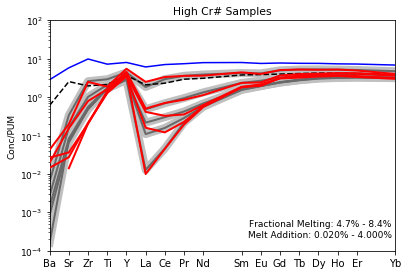

In [51]:
rx1=[2.3,0.002] # works well-ish for all except index 3, which comes back negative
rx2=[1,0.002] # everything at least comes back positive, but Cr#s don't go up by enough
rx3=[1.2,0.001] # everything at least comes back positive, but Cr#s don't go up by enough

# after fixing m mistake
rx4 = [0.01,0.00002]
rx5 = [0.01,0.01] # works decently well, but everything could be higher
rx6 = [0.016,0.002]

# after making it logarithmic
rx7 = [0.0025,0.002,100] # not bad! nothing too crazy!
rx8 = [0.0020,0.002,150]

F_hiCr, Fm_hiCr, Cr_res_hiCr, Cr_new_hiCr = melt_model(hi_Cr_hi_fO2_dicts, NMORB, xtal_modes=MORB, normalization=PUM, 
                                              method='custom1', subsolidus_reaction = 'spinel-to-plag', ss_rxn_amt=rx8,
                                                     group_color='r', plot_title='High Cr# Samples',
                                                         output=True, model_plot='individual', speed='fast')

In [ ]:
melt_model(SWIR_Van78, NMORB, xtal_modes=MORB, normalization=PUM, method='custom1', 
                subsolidus_reaction = 'spinel-to-plag', ss_rxn_amt=[0.0005,0.002,100], group_color='maroon', plot_title='SWIR Van78 Samples',
                    output=True, model_plot='individual', speed='fast')

In [ ]:
melt_model([hi_Cr_hi_fO2_dicts[1]], NMORB, xtal_modes=MORB, normalization=PUM, method='custom1', 
                subsolidus_reaction = 'spinel-to-plag', ss_rxn_amt=[0.00246,0.002,110], group_color='r', plot_title='High Cr# Samples',
                    output=True, model_plot='individual', speed='fast')

In [ ]:
x=np.linspace(0,6,100)
y= 0.0025*np.log(x*100 + 1) + 0.002

plt.plot(x,y)

In [ ]:
# Replication of the model from Birner et al., 2017

d106 = {
    'Ba': 0.347,
    'Pb': 0.0358,
    'Sr': 2.25,
    'Nb': 0.0157,
    'Zr': 0.492,
    'Ti': 397.269,
    'Y' : 2.53,
    'La': 0.0322,
    'Ce': 0.0998,
    'Pr': 0.0146,
    'Nd': 0.0824,
    'Sm': 0.0591,
    'Eu': 0.0304,
    'Gd': 0.201,
    'Tb': 0.0459,
    'Dy': 0.375,
    'Ho': 0.0998,
    'Er': 0.318,
    'Yb': 0.345   
}
    
melt_model([d106], Tonga_IAT, xtal_modes={'olv':0.7, 'opx':0, 'cpx':0.3, 'spl':0, 'plg':0}, 
                         normalization=PUM, method='extended', output=False)

In [ ]:
# Pull out parameters for cpx trace element samples of each type

TiO2_lowCr = TiO2[low_Cr & cpx_trace.astype(bool)]
TiO2_hiCr = TiO2[hi_Cr_hi_fO2 & cpx_trace.astype(bool)]

plag_lowCr = plag_score[low_Cr & cpx_trace.astype(bool)]
plag_hiCr = plag_score[hi_Cr_hi_fO2 & cpx_trace.astype(bool)]

Cr_lowCr = Cr_num[low_Cr & cpx_trace.astype(bool)]
Cr_hiCr = Cr_num[hi_Cr_hi_fO2 & cpx_trace.astype(bool)]

fO2_lowCr = fO2[low_Cr & cpx_trace.astype(bool)]
fO2_hiCr = fO2[hi_Cr_hi_fO2 & cpx_trace.astype(bool)]

In [ ]:
fig = plt.figure()
fig.set_size_inches(3.5, 10)
    
y=0.18
ax0 = fig.add_axes([0.05, 0.1+4*y, 0.8, y]) # left, bottom, width, height (range 0 to 1)
ax1 = fig.add_axes([0.05, 0.1+3*y, 0.8, y]) # left, bottom, width, height (range 0 to 1)
ax2 = fig.add_axes([0.05, 0.1+2*y, 0.8, y]) # left, bottom, width, height (range 0 to 1)
ax3 = fig.add_axes([0.05, 0.1+y, 0.8, y]) # left, bottom, width, height (range 0 to 1)
ax4 = fig.add_axes([0.05, 0.1, 0.8, y]) # left, bottom, width, height (range 0 to 1)

xmax = max(Fm_hiCr + 0.1)


### Fractional Melting ###

ax0.scatter(Fm_lowCr, F_lowCr, color='k')
ax0.scatter(Fm_hiCr, F_hiCr, color='r')

ax0.set_xlim([-0.1,xmax])
ax0.set_ylim([-0.5,20])
ax0.set_xticks([])
ax0.set_ylabel('% Fractional Melting')

### TiO2 in Spinel ###

ax1.scatter(Fm_lowCr, TiO2_lowCr, color='k')
ax1.scatter(Fm_hiCr, TiO2_hiCr, color='r')

ax1.set_xlim([-0.1,xmax])
ax1.set_ylim([0,0.6])
ax1.set_xticks([])
ax1.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax1.set_ylabel('% TiO$_2$ in Spinel')

### Plagioclase ###

ax2.scatter(Fm_lowCr, plag_lowCr, color='k')
ax2.scatter(Fm_hiCr, plag_hiCr, color='r')
ax2.axhline(1, linestyle='--', linewidth=1, color='k', zorder=0)
ax2.axhline(2, linestyle='--', linewidth=1, color='k', zorder=0)
ax2.axhline(3, linestyle='--', linewidth=1, color='k', zorder=0)
ax2.axhline(4, linestyle='--', linewidth=1, color='k', zorder=0)
ax2.axhline(5, linestyle='--', linewidth=1, color='k', zorder=0)

ax2.set_xlim([-0.1,xmax])
ax2.set_ylim([0,6])
ax2.set_xticks([])
ax2.set_yticks([1,2,3,4,5])
ax2.set_ylabel('Plagioclase')

### Cr# ###

ax3.scatter(Fm_lowCr, Cr_lowCr, color='k')
ax3.scatter(Fm_hiCr, Cr_hiCr, color='r')

ax3.set_xlim([-0.1,xmax])
ax3.set_ylim([0,60])
ax3.set_xticks([])
ax3.set_yticks([0,10,20,30,40,50,60])
ax3.set_ylabel('Cr#')

### fO2 ###

ax4.scatter(Fm_lowCr, fO2_lowCr, color='k')
ax4.scatter(Fm_hiCr, fO2_hiCr, color='r')
ax4.axhline(0, linestyle='--', linewidth=1, color='k')

ax4.set_xlim([-0.1,xmax])
ax4.set_ylim([-2,2])
ax4.set_yticks([-1.5,-0.5, 0.5, 1.5])
ax4.set_xlabel('% Melt Addition')
ax4.set_ylabel('log($f_{O2}$), $\Delta$QFM')


plt.show()

In [ ]:
fig = plt.figure()
fig.set_size_inches(4, 3)
    
ax0 = fig.add_axes([0.05, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

ax0.scatter(Cr_lowCr, Cr_res_lowCr, color='silver')
ax0.scatter(Cr_lowCr, Cr_new_lowCr, color='k')
ax0.scatter(Cr_hiCr, Cr_res_hiCr, color='salmon')
ax0.scatter(Cr_hiCr, Cr_new_hiCr, color='r')
#ax0.scatter(Cr_num[hi_Cr_low_fO2], melt_model_output[hi_Cr_low_fO2][:,2], color='b')
#ax0.scatter(melt_model_output[no_cat][:,1], Cr_num[no_cat], color='purple')

ax0.plot([0,60],[0,60], linestyle='--', color='gray', zorder=0)

#ax1.scatter(Cr_global, TiO2_global, s=10, color='silver')

#ax0.set_xscale('log')

ax0.set_ylim([0,60])
ax0.set_xlim([0,60])
ax0.set_xlabel('Cr# actual')
ax0.set_ylabel('Cr# predicted')

plt.show()